<a href="https://colab.research.google.com/github/radonys/Job-Description-Classification/blob/master/YashSrivastava_9873657119.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction


**Probelm Statement:** Make a classifier which takes in a job description and gives the department name for it.
*   Use a neural network model
*   Make use of a pre-trained Word Embeddings (example: Word2Vec, GloVe, etc.)
*   Calculate the accuracy on a test set (data not used to train the model)

**Problem Solving Approach:** 
_Provide a brief description of steps you followed for solving this problem_
1.  First, I started with the process of reading text input and and combining the two given data files.
2. Then, I looked upon the various neural network based methods of text classification and found that BERT performed the best and hence used the same.
3. Performed EDA and found the department distribution along with the number of jobs with no description.
4. Jobs without description were removed from the dataset.
5. Converted dataset to feed to the BERT framework.
6. Used the BERT-UNCASED-12 layer pre-trained model for training the network. Basic model used due to memory limitations.
7. Computed results and evaluations.

### Part I: Text Preprocessing

_Include all text preprocesing steps like processing of json,csv files & data cleaning in this part._

Import neccessary packages in below cell

In [0]:
import os, json
import pandas as pd

Get the Data Files

In [0]:
!git clone https://bitbucket.org/mohitatbb/machine-learning-assessment.git
!mv /content/machine-learning-assessment/data /content/
!rm -rf /content/machine-learning-assessment

Cloning into 'machine-learning-assessment'...
remote: Counting objects: 1170, done.
remote: Compressing objects: 100% (998/998), done.
remote: Total 1170 (delta 171), reused 1170 (delta 171)
Receiving objects: 100% (1170/1170), 868.64 KiB | 941.00 KiB/s, done.
Resolving deltas: 100% (171/171), done.


Load JSON files in Pandas DataFrame and printing top values.

In [0]:
path_to_json = '/content/data/docs'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

description_data = pd.DataFrame(columns=['Document ID', 'description'])

for index, js in enumerate(json_files):  
  with open(os.path.join(path_to_json, js)) as json_file:
    
    json_text = json.load(json_file)
    doc_id = int(json_text['_id'])
    description = json_text['jd_information']['description']
    description_data.loc[index] = [doc_id, description]

print(description_data.head())

  Document ID                                        description
0     8283481                                                   
1     8177688                                                   
2     8257849  Urgent opening for the position of Travel exec...
3     8014068                                                   
4     6978079  Need Urgent for Marketing Head Cum Corporate c...


Read Department CSV file and view top values.

In [0]:
department_csv = '/content/data/document_departments.csv'
department_data = pd.read_csv(department_csv)
print(department_data.head())

   Document ID             Department
0      8196431       Customer service
1      8278123      Digital Marketing
2      8331625                  Sales
3      8331003  Back office ticketing
4      8277939      Digital Marketing


Combine both Data Frames and visualize.

In [0]:
data_combine = pd.merge(description_data, department_data, on='Document ID', how='inner')
print(data_combine.head())

  Document ID  ...         Department
0     8283481  ...          Ticketing
1     8177688  ...          Ticketing
2     8257849  ...          Ticketing
3     8014068  ...  Digital Marketing
4     6978079  ...          Ticketing

[5 rows x 3 columns]


### Part II: Exploratoty Data Analysis

_Include EDA steps like finding distribution of Departments in this part, you may also use plots for EDA._

Import necessary analysis modules.

In [0]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

Plotting Department distribution.

['Back office ticketing', 'Marine Service Steward ', 'Maintenance', 'Airline Ground Operations', 'Technology', 'Marine Engineering ', 'Administration', 'Analytics', 'Procurement', 'Safety ', 'Ticketing', 'Digital Marketing', 'IT', 'Flight Operations', 'Customer service', 'Sales', 'Recruitment', 'Public Relations ', 'Operations', 'Marketing', 'Logistics', 'Management Consulting', 'Presales ', 'Data entry', 'QA ', 'Finance', 'Learning and Development ', 'Content', 'Engineering Design Construction', 'Marine Deck ']


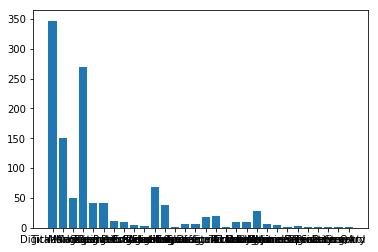

In [0]:
unique_departments = list(set(data_combine['Department']))
count = dict(Counter(data_combine['Department']))
print(unique_departments)

plt.bar(range(len(count)), list(count.values()), align='center')
plt.xticks(range(len(count)), list(count.keys()))
plt.show()

Statistical Information of the Given Data.

In [0]:
data_combine.describe()

,Document ID,description,Department
count,1162,1162,1162
unique,1162,619,30
top,7802879,,Ticketing
freq,1,417,347


Number of empty description string rows in data.

In [0]:
remove_list = []

total = data_combine.shape[0]

for i in range(0,len(data_combine['description'])):
  
  if data_combine['description'][i] == '':
    remove_list.append(i)

data_combine_description = data_combine.drop(remove_list, axis=0)

remaining = data_combine_description.shape[0]

empty_descriptions = total - remaining
print("Number of Empty descriptions: ", empty_descriptions)

Number of Empty descriptions:  417


### Part III: Modelling & Evaluation

_Include all model prepration & evaluation steps in this part._

In [0]:
from sklearn.model_selection import train_test_split
import os

Paths to BERT files obtained from Google Research BERT open-source.

In [0]:
!rm -rf bert
!rm -rf uncased_L-12_H-768_A-12

!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip uncased_L-12_H-768_A-12.zip
!rm uncased_L-12_H-768_A-12.zip

BERT_VOCAB= 'uncased_L-12_H-768_A-12/vocab.txt'
BERT_INIT_CHKPNT = 'uncased_L-12_H-768_A-12/bert_model.ckpt'
BERT_CONFIG = 'uncased_L-12_H-768_A-12/bert_config.json'

--2019-06-02 08:47:45--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.26.48, 2404:6800:4004:818::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.26.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   108MB/s    in 3.6s    

2019-06-02 08:47:49 (108 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


Prepare Training Data for BERT Model.

In [0]:
data_combine_description['bert_required_character'] = 'a'
data_combine_description = data_combine_description[['Document ID', 'Department', 'bert_required_character', 'description']]
data_combine_description.head()

,Document ID,Department,bert_required_character,description
2,8257849,Ticketing,a,Urgent opening for the position of Travel exec...
4,6978079,Ticketing,a,Need Urgent for Marketing Head Cum Corporate c...
7,8245653,Ticketing,a,TALENT HUNTER HIRING FOR MNC COMPANY FOR INBOU...
8,8305743,Sales,a,Job Responsibilities:&bull; Attending to appoi...
9,8115997,Digital Marketing,a,TFG VACATIONS INDIA is a travel &amp; tourism ...


Train-Test Split Data

In [0]:
train, test = train_test_split(data_combine_description, test_size=0.2)

Save TSV files.

In [0]:
!mkdir modified_data

train.to_csv('modified_data/train.tsv', sep='\t', index=False, header=False)
test.to_csv('modified_data/dev.tsv', sep='\t', index=False, header=False)

In [0]:
!pip install bert-tensorflow
!wget https://raw.githubusercontent.com/radonys/Job-Description-Classification/master/run_classifier.py

In [0]:
!python run_classifier.py \
--task_name=cola \
--do_train=true \
--do_eval=true \
--data_dir=modified_data \
--vocab_file=uncased_L-12_H-768_A-12/vocab.txt \
--bert_config_file=uncased_L-12_H-768_A-12/bert_config.json \
--init_checkpoint=uncased_L-12_H-768_A-12/bert_model.ckpt \
--max_seq_length=128 \
--train_batch_size=32 \
--learning_rate=2e-5 \
--num_train_epochs=10 \
--output_dir=bert_output/


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Using config: {'_model_dir': 'bert_output/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f73d1834a90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': T

**Results Summary:**
_Provide a brief summary of results obtained like model accuracy & other insights based on EDA & your interpretations_

1. 
2. 
3. 